In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
listing_data = pd.read_csv("./data/modelling_data")
listing_data.head()

,id,name,borough,neighbourhood,price,bathrooms,accommodates,bedrooms,beds,room_type,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,275,1.0,4,2.0,2.0,3,...,0,0,0,0,0,0,1,0,0,0
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,75,1.0,1,1.0,1.0,2,...,0,0,0,0,0,0,0,1,0,0
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,60,1.0,2,1.0,1.0,2,...,0,0,0,0,0,0,1,0,0,0
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,68,1.0,2,1.0,1.0,2,...,0,0,0,0,0,0,0,1,0,0
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,65,1.0,1,1.0,1.0,2,...,0,0,0,0,0,0,0,1,0,0


In [3]:
listings = listing_data.drop(['id','name','borough','neighbourhood'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns='price'),
                                                    listings.price, test_size=0.3,
                                                    random_state=18)

In the previous step, the random forest regression with default parameters had the following performance metrics:
- R-squared: 0.5003891180573756
- RMSE: 115.57067302453866
- MAE: 67.51

I will perform a gridsearchCV to tune the parameters and calculate the new performance.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 100}
Best score: 0.4970269444588169


In [6]:
rfr = RandomForestRegressor(random_state=18)
rfr.set_params(**grid_search.best_params_)
# rfr.set_params(**{'max_depth': 15, 'n_estimators': 90})
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("RMSE:", np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print("Using these parameters, this random forest model's predictions would be off by an average of ${}".format(round(mae,2)))

R-squared: 0.5111310357774904
RMSE: 114.32150452734955
Using these parameters, this random forest model's predictions would be off by an average of $66.88


This is a slight improvement. Will try engineering additional features.

# Engineering and adding more features 

The following are popular landmarks from each borough of New York City: <br>

- **Manhattan**: Empire State Building (40.7485° N, 73.9857° W)
- **Brooklyn**: Brooklyn Bridge (40.7061° N, 73.9969° W)
- **Queens**: Flushing Meadows-Corona Park (40.7400° N, 73.8407° W)
- **The Bronx**: Yankee Stadium (40.8296° N, 73.9262° W)
- **Staten Island**: Staten Island Ferry (40.6437° N, 74.0719° W)

In [7]:
coordinate_data = pd.read_csv('./data/coordinate_data')
coordinate_data.head()

,id,name,longitude,latitude,price,borough
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan


In [8]:
landmarks = {
    'Manhattan': {'name': 'Empire State Building', 'lat': 40.7485, 'lon': -73.9857},
    'Brooklyn': {'name': 'Brooklyn Bridge', 'lat': 40.7061, 'lon': -73.9969},
    'Queens': {'name': 'Flushing Meadows - Corona Park', 'lat': 40.7400, 'lon': -73.8407},
    'Bronx': {'name': 'Yankee Stadium', 'lat': 40.8296, 'lon': -73.9262},
    'Staten Island': {'name': 'Staten Island Ferry', 'lat': 40.6437, 'lon': -74.0719}
}

In [9]:
import math

# defining a function to calculate the distance between a listing and its respective landmark
def haversine_distance(row):
    # getting the name and coordinate of landmark for the borough of the listing
    borough = row['borough']
    landmark_name = landmarks[borough]['name']
    landmark_lat = landmarks[borough]['lat']
    landmark_lon = landmarks[borough]['lon']

    # getting the lat and lon of the listing
    lat = row['latitude']
    lon = row['longitude']
    
    # converting the lat and lon to radians
    lat, lon, landmark_lat, landmark_lon = map(math.radians, [lat, lon, landmark_lat, landmark_lon])

    # Haversine formula
    dlon = landmark_lon - lon
    dlat = landmark_lat - lat
    a = math.sin(dlat / 2) ** 2 + math.cos(lat) * math.cos(landmark_lat) * math.sin(dlon / 2) ** 2
    c = 2 *math.asin(math.sqrt(a))
    r = 6371 # earth radius
    distance = c * r
    return distance, landmark_name

In [10]:
# Calculate the distance between each listing and its respective landmark
coordinate_data[['landmark_distance_km', 'landmark_name']] = coordinate_data.apply(haversine_distance, axis=1, result_type='expand')

In [11]:
coordinate_data.head()

,id,name,longitude,latitude,price,borough,landmark_distance_km,landmark_name
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn,4.835516,Brooklyn Bridge
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan,6.336971,Empire State Building
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn,4.210733,Brooklyn Bridge
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan,1.799564,Empire State Building
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan,6.882754,Empire State Building


In [12]:
coordinate_data['id'].nunique()

35722

In [13]:
df_df = pd.merge(listing_data, coordinate_data[['landmark_distance_km','id']], on=['id'], how='left')

In [14]:
df = df_df.drop(["id","name", "borough", "neighbourhood"], axis=1)

In [15]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [16]:
param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 90}
Best score: 0.529865258218201


As this Grid Search produced a better score than the previous, I will use the new best parameters.

In [17]:
rfr = RandomForestRegressor(random_state=18)
# rfr.set_params(max_depth=10, n_estimators=90)
rfr.set_params(**grid_search.best_params_)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
r2_rfr = r2_score(y_test, y_pred)
mse_rfr = mean_squared_error(y_test, y_pred)
print("R-squared:", r2_rfr)
print("RMSE:", np.sqrt(mse_rfr))
mae_rfr = mean_absolute_error(y_test, y_pred)
print("This random forest model's predictions would be off by an average of ${}".format(round(mae_rfr,2)))

R-squared: 0.5306806272747717
RMSE: 112.0123577013683
This random forest model's predictions would be off by an average of $65.8


This model's performance has been the best so far. 

Finally, I'll try the popular gradient boosting model with XGBoost to see if it improves upon the RandomForest.

In [19]:
import xgboost as xgb

# Define the parameter grid to search over
param_grid = {
    'max_depth': np.arange(3,8),
    'learning_rate': [0.01, 0.05, 0.1,0.3],
    'n_estimators': [50,100,200]
}

# Use GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(), 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [20]:
# Fit the grid search object to the training data
xgb_reg = xgb.XGBRegressor(**grid_search.best_params_)
# xgb_reg = xgb.XGBRegressor(max_depth=7, learning_rate=0.05, n_estimators=200)
xgb_reg.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")
print("The best model's predictions would be off by an average of ${}.".format(round(mae,2)))

Root mean squared error: 110.38161131886908
The best model's predictions would be off by an average of $65.0.


There is a some performance improvement with the boosted model, however the RFR can be trained in half the time it takes the boosted model to train.

## Feature Analysis

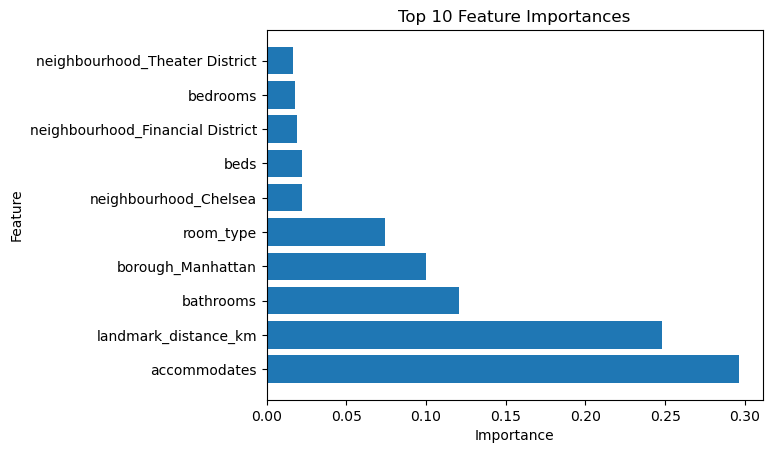

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from our random forest model
importances = rfr.feature_importances_
#plot the top ten most important features in a horizontal bar chart
plt.barh(X.columns[np.argsort(importances)[::-1][:10]], importances[np.argsort(importances)[::-1][:10]])
#label the chart
plt.title('Top 10 Feature Importances')
#label the axes
plt.xlabel('Importance')
plt.ylabel('Feature')
#display the plot
plt.show()

## Profitability Analysis

In the context of this project, we will assume the model being used by the hiring company takes the average price per neighborhood and number of beds.

This will allow comparison of my model's predictions to that of baseline model's and the actual price. 

In the following step, I will estimate the revenue generated by both models by using occupancy information.

In [22]:
# preparing test set for analysis
indices = X_test.index
X_test_subset = df_df.loc[indices].copy()

In [23]:
X_test_subset['predicted_price'] = y_pred

In [24]:
X_test_subset['naive_price'] = X_test_subset.groupby(['neighbourhood', 'beds'])['price'].transform('mean')

In [25]:
X_test_subset[["price", "predicted_price", "naive_price"]]

,price,predicted_price,naive_price
24266,723,291.279846,320.818182
25828,95,168.781067,95.000000
14175,100,88.731644,82.385965
10743,100,81.859138,96.155945
4112,84,80.299072,98.456376
...,...,...,...
26192,51,98.316856,138.799603
23488,259,228.307007,195.388889
24898,127,116.192314,128.842105
21446,38,54.536064,68.239130


Occupancy rate is calculated as the ratio of the number of nights the listing was booked to the total number of nights in a year.

In [26]:
from datetime import datetime

df_occupancy = pd.read_csv("./data/source/calendar.csv.gz", low_memory=False)
df_occupancy.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5136,2022-12-04,f,$275.00,$275.00,21.0,1125.0
1,2595,2022-12-05,t,$175.00,$175.00,30.0,1125.0
2,2595,2022-12-06,t,$175.00,$175.00,30.0,1125.0
3,2595,2022-12-07,t,$175.00,$175.00,30.0,1125.0
4,2595,2022-12-08,t,$175.00,$175.00,30.0,1125.0


In [27]:
df_occupancy['date'] = pd.to_datetime(df_occupancy['date'])

In [28]:
available_listings = df_occupancy[df_occupancy['available'] == 't']
available_days = available_listings.groupby('listing_id')['date'].nunique().reset_index()
available_days.rename(columns={'date': 'available_days'}, inplace=True)
available_days.head()

,listing_id,available_days
0,2595,365
1,5121,322
2,5136,267
3,5178,79
4,5803,163


In [29]:
total_days = df_occupancy.groupby('listing_id')['date'].nunique().reset_index()
total_days.rename(columns={'date': 'total_days'}, inplace=True)

In [30]:
occupancy = pd.merge(total_days, available_days, on='listing_id')
occupancy['occupancy_rate'] = ((occupancy['total_days'] - occupancy['available_days']) / occupancy['total_days']) * 100

In [31]:
occupancy.head()

,listing_id,total_days,available_days,occupancy_rate
0,2595,365,365,0.000000
1,5121,365,322,11.780822
2,5136,365,267,26.849315
3,5178,365,79,78.356164
4,5803,365,163,55.342466


In [32]:
merged = pd.merge(occupancy[['occupancy_rate','listing_id']], X_test_subset, left_on='listing_id', right_on='id')

In [33]:
predicted_revenue = merged['occupancy_rate'] * merged['predicted_price'] * 365
naive_revenue = merged['occupancy_rate'] * merged['naive_price'] * 365

revenue_difference = predicted_revenue - naive_revenue

In [34]:
revenue_difference.sum()

301449306.70310193

In [35]:
revenue_compared = (predicted_revenue.sum() - naive_revenue.sum()) / naive_revenue.sum() * 100


In [36]:
revenue_compared

1.514232463390026

For the evaluated listings, over the course of 12 months, our model generated $301,449,306.70 more in revenue than the hypothetical model. This is a 1.5% increase in revenue.

# NEXT STEPS

#### 1. Additional feature engineering:
  - Using `amenities` as an additional feature.
  - Using different landmarks - possibly extracted from the `name` feature using NLP.
  - Analyzing the top reviewed listings and top hosts to gather isnights on what makes a listing successful.

#### 2. Apply models on other cities
  - The models can be applied to other cities to see if the same features are important in predicting price.

#### 3. Use different models:
  - Try other models such as Support Vector Machines, Neural Networks, etc.

In [37]:
metrics = pd.DataFrame({'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R^2 Score'],
                       'Value': [mae_rfr, mse_rfr, np.sqrt(r2_rfr), r2_rfr]})
metrics.to_csv('./data/metrics.csv', index=False)